In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    "/storage/vbutoi/scratch/ESE/training/10_10_24_Roads_FullRes_big_SoftDice",
    "/storage/vbutoi/scratch/ESE/training/10_21_24_Roads_FullRes_big_CrossEntropy",
    "/storage/vbutoi/scratch/ESE/training/10_21_24_Roads_FullRes_Cleaned_CrossEntropy",
    "/storage/vbutoi/scratch/ESE/training/10_21_24_Roads_FullRes_Cleaned_SoftDice",
    "/storage/vbutoi/scratch/ESE/training/10_21_24_Roads_RandomCrop500_Cleaned_CrossEntropy",
    "/storage/vbutoi/scratch/ESE/training/10_21_24_Roads_RandomCrop500_Cleaned_SoftDice",
    "/storage/vbutoi/scratch/ESE/training/10_12_24_Roads_RandomCrop500_big_CrossEntropy",
    "/storage/vbutoi/scratch/ESE/training/10_12_24_Roads_RandomCrop500_big_SoftDice",
]

df_list_1 = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list_1.append(df)
    except Exception as e:
        print(e)

df = pd.concat(df_list_1)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
df['lr'].unique()

array([0.0001])

In [4]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
abs_area_estimation_error
area_estimation_error
dice_score
ece_loss
data
in_channels
out_channels
train_kwargs_split
val_kwargs_split
version
batch_size
num_workers
pin_memory
seed
torch_compile
torch_mixed_precision
loss_func
batch_reduction
from_logits
model
convs_per_block
filters
optim
lr
epochs
eval_freq
path
train_kwargs_transforms
val_kwargs_transforms


In [5]:
df['train_kwargs_transforms'].unique()

array([nan,
       '[{"albumentations.RandomCrop": {"height": 500, "width": 500}}]'],
      dtype=object)

In [6]:
# Fill the train_kwargs_transforms with None if it is NaN
df['train_kwargs_transforms'] = df['train_kwargs_transforms'].fillna('None')

In [7]:
def exp_name(path):
    exp_root = str(path).split("/")[-2]
    return exp_root

def aug_type(path):
    exp_root = str(path).split("/")[-2]
    if exp_root == "09_26_24_ISLES_3D_LTS_AllAug_v2_ElasticOnly":
        exp_n = "spatial"
    elif exp_root == "09_26_24_ISLES_3D_LTS_AllAugBackbone_v2":
        exp_n = "intensity + spatial"
    else:
        raise ValueError("Unknown experiment root")
    return exp_n

def patch_based(train_kwargs_transforms):
    if train_kwargs_transforms == "None":
        return "False"
    else:
        return "True"

df.augment(exp_name)
df.augment(patch_based)

In [8]:
# We want to make sure that train goes before val in the phase
df['phase'] = df['phase'].astype('category')
df['version'] = df['version'].astype('category')
df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)

<ipython-input-8-8216696af331>:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df['phase'].cat.reorder_categories(['train', 'val'], inplace=True)


In [9]:
# Get every 10 epochs
df = df[df['epoch'] % 10 == 0]
# I only want seed = 40 for now
df = df[df['seed'] == 40]

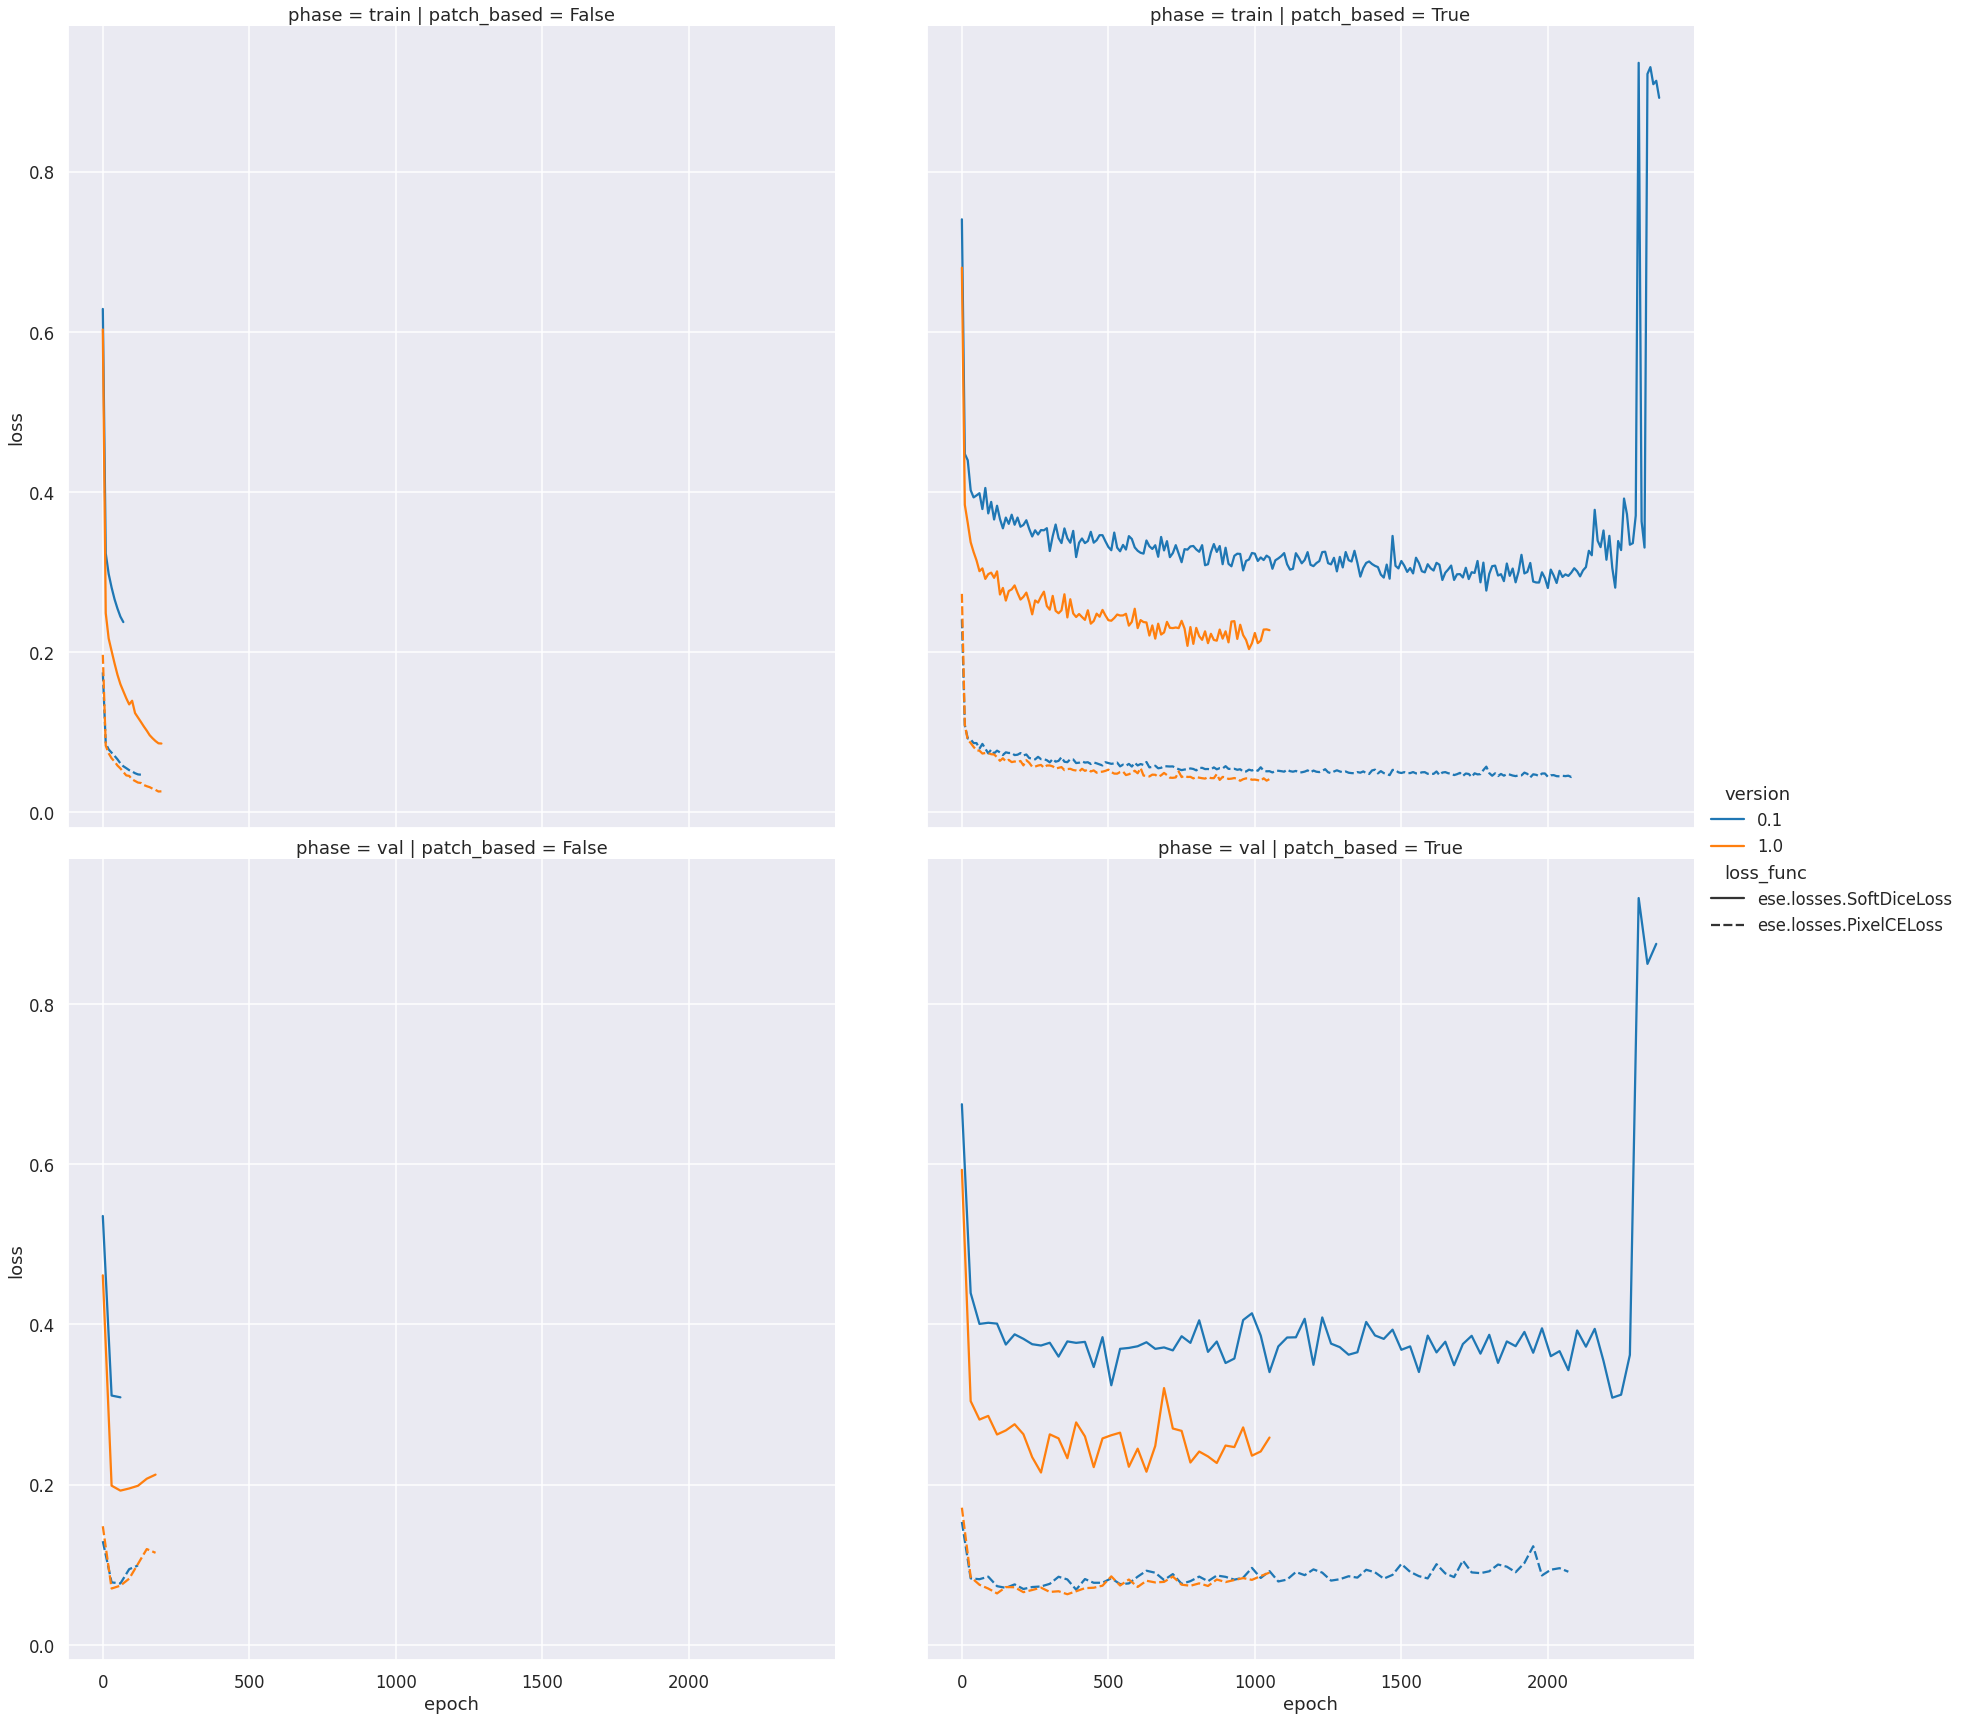

In [10]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='version',
    style='loss_func',
    row='phase',
    col='patch_based',
    kind='line',
    height=12,
    # facet_kws=dict(sharey=False),
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.12)
# Set the y axis to be between 0 and 1
# g.set(ylim=(0, 1000))

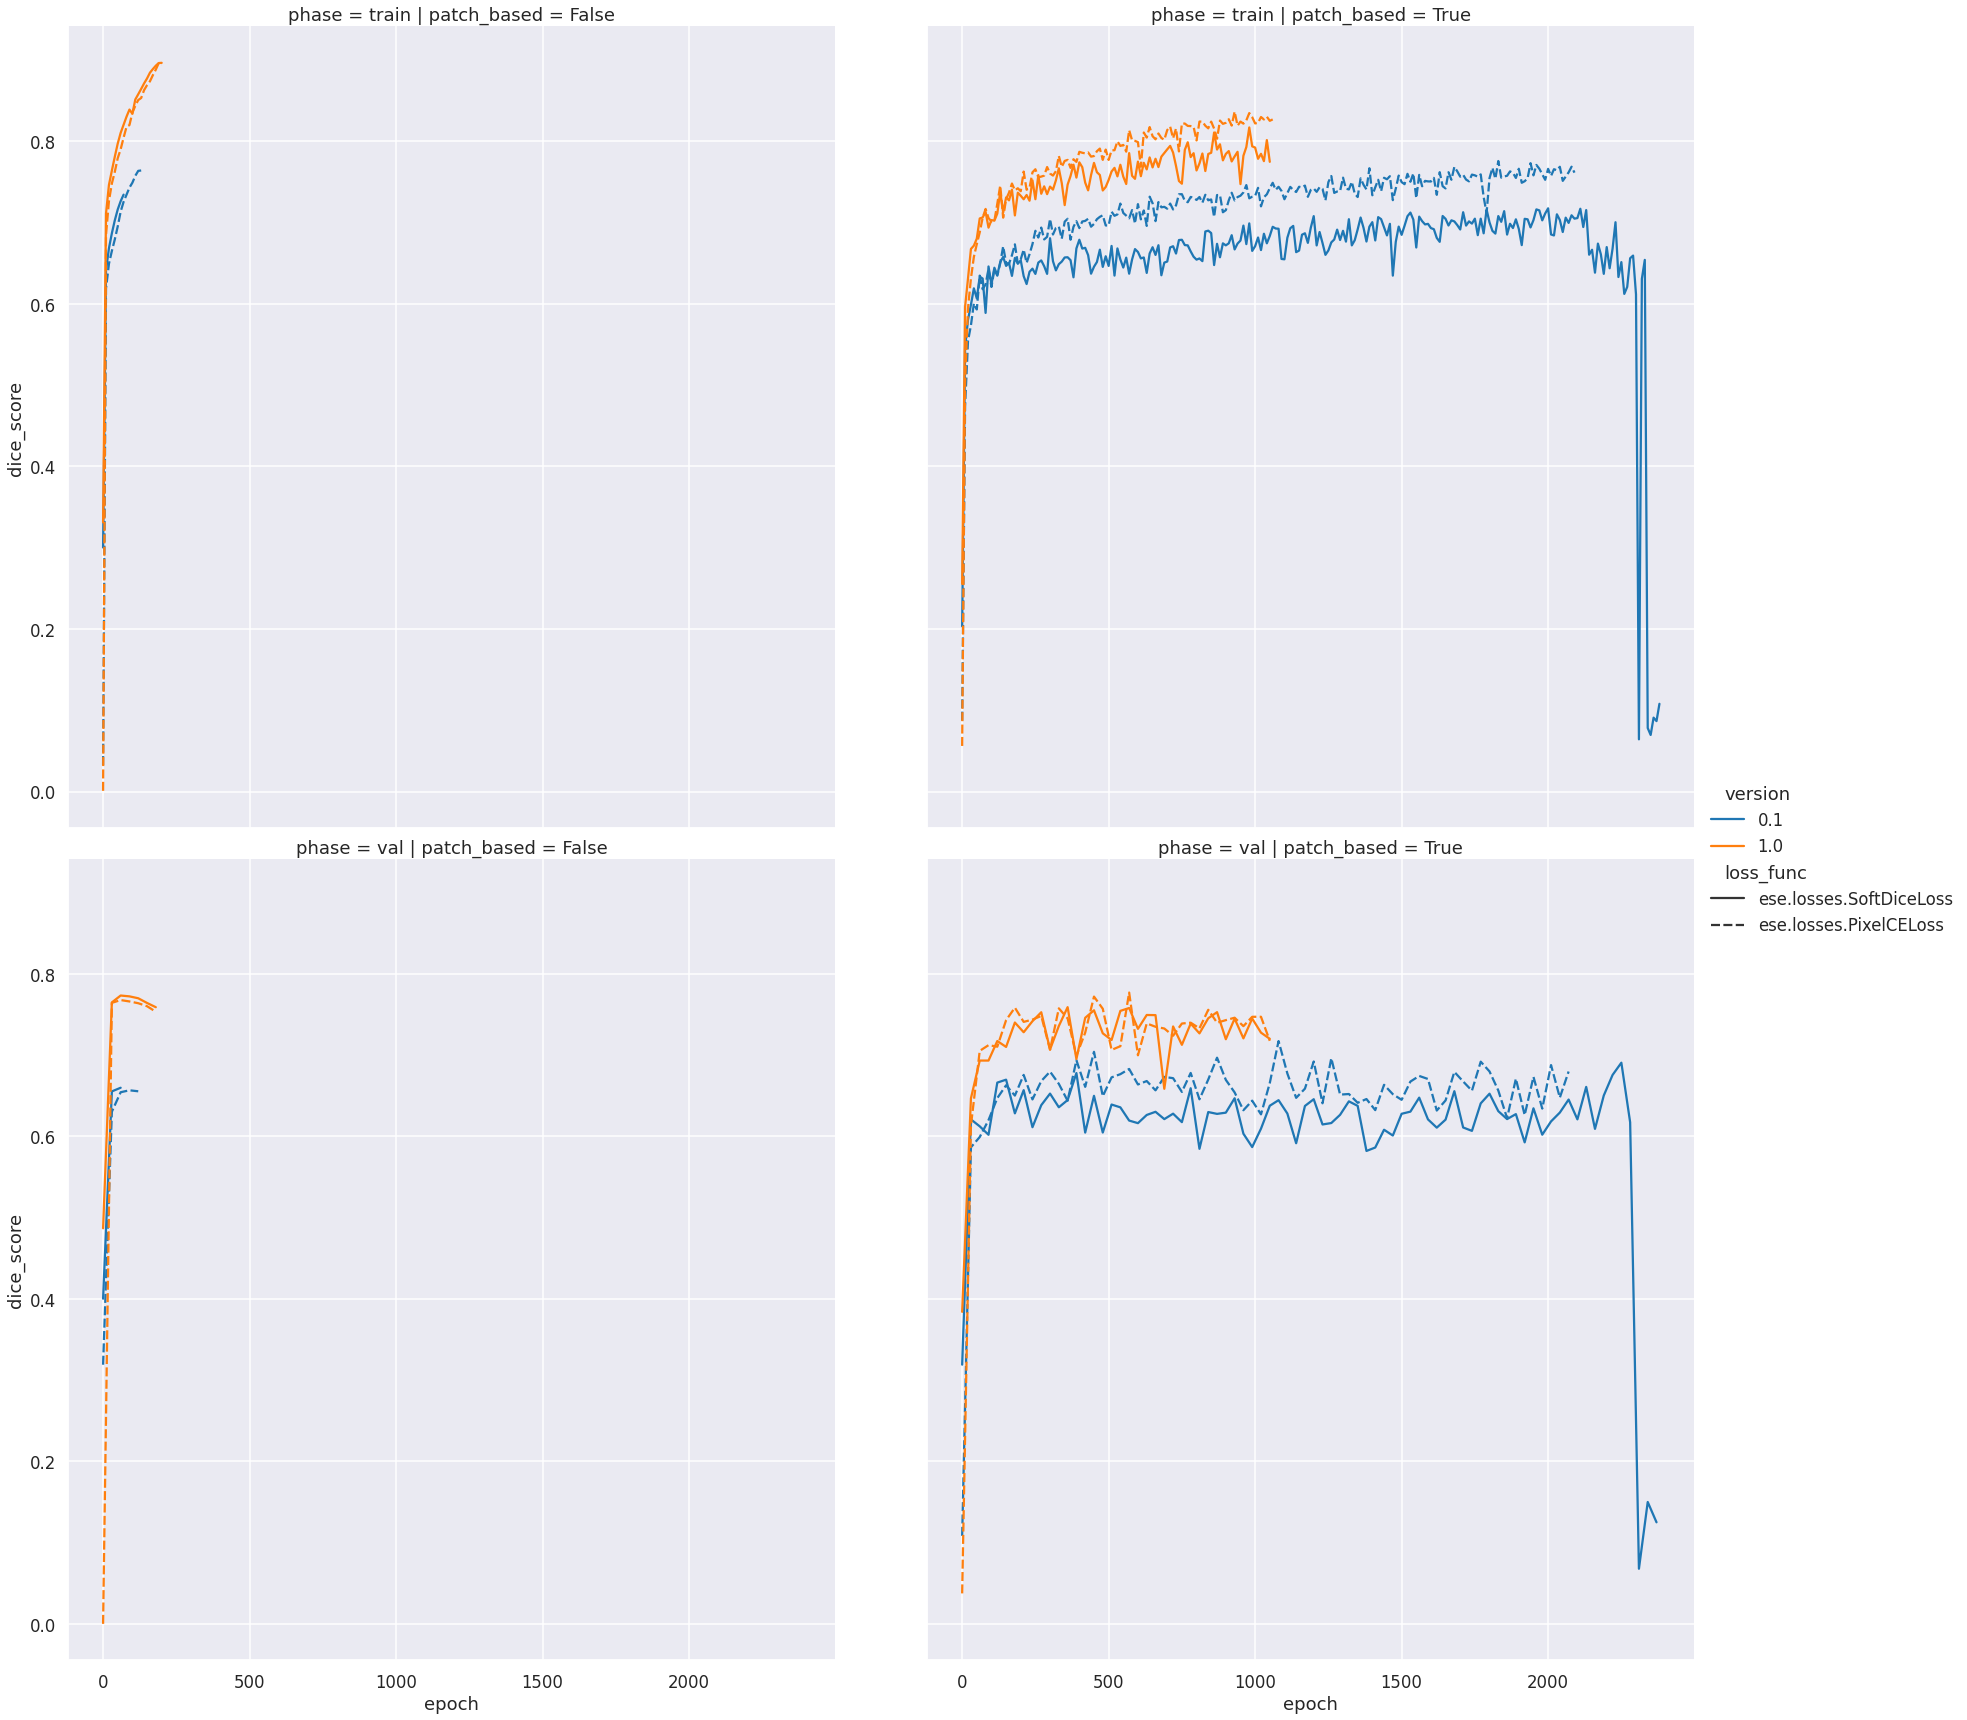

In [11]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='dice_score',
    hue='version',
    style='loss_func',
    row='phase',
    col='patch_based',
    kind='line',
    height=12,
    # facet_kws=dict(sharey=False),
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.12)
# Set the y axis to be between 0 and 1
# g.set(ylim=(0, 1000))

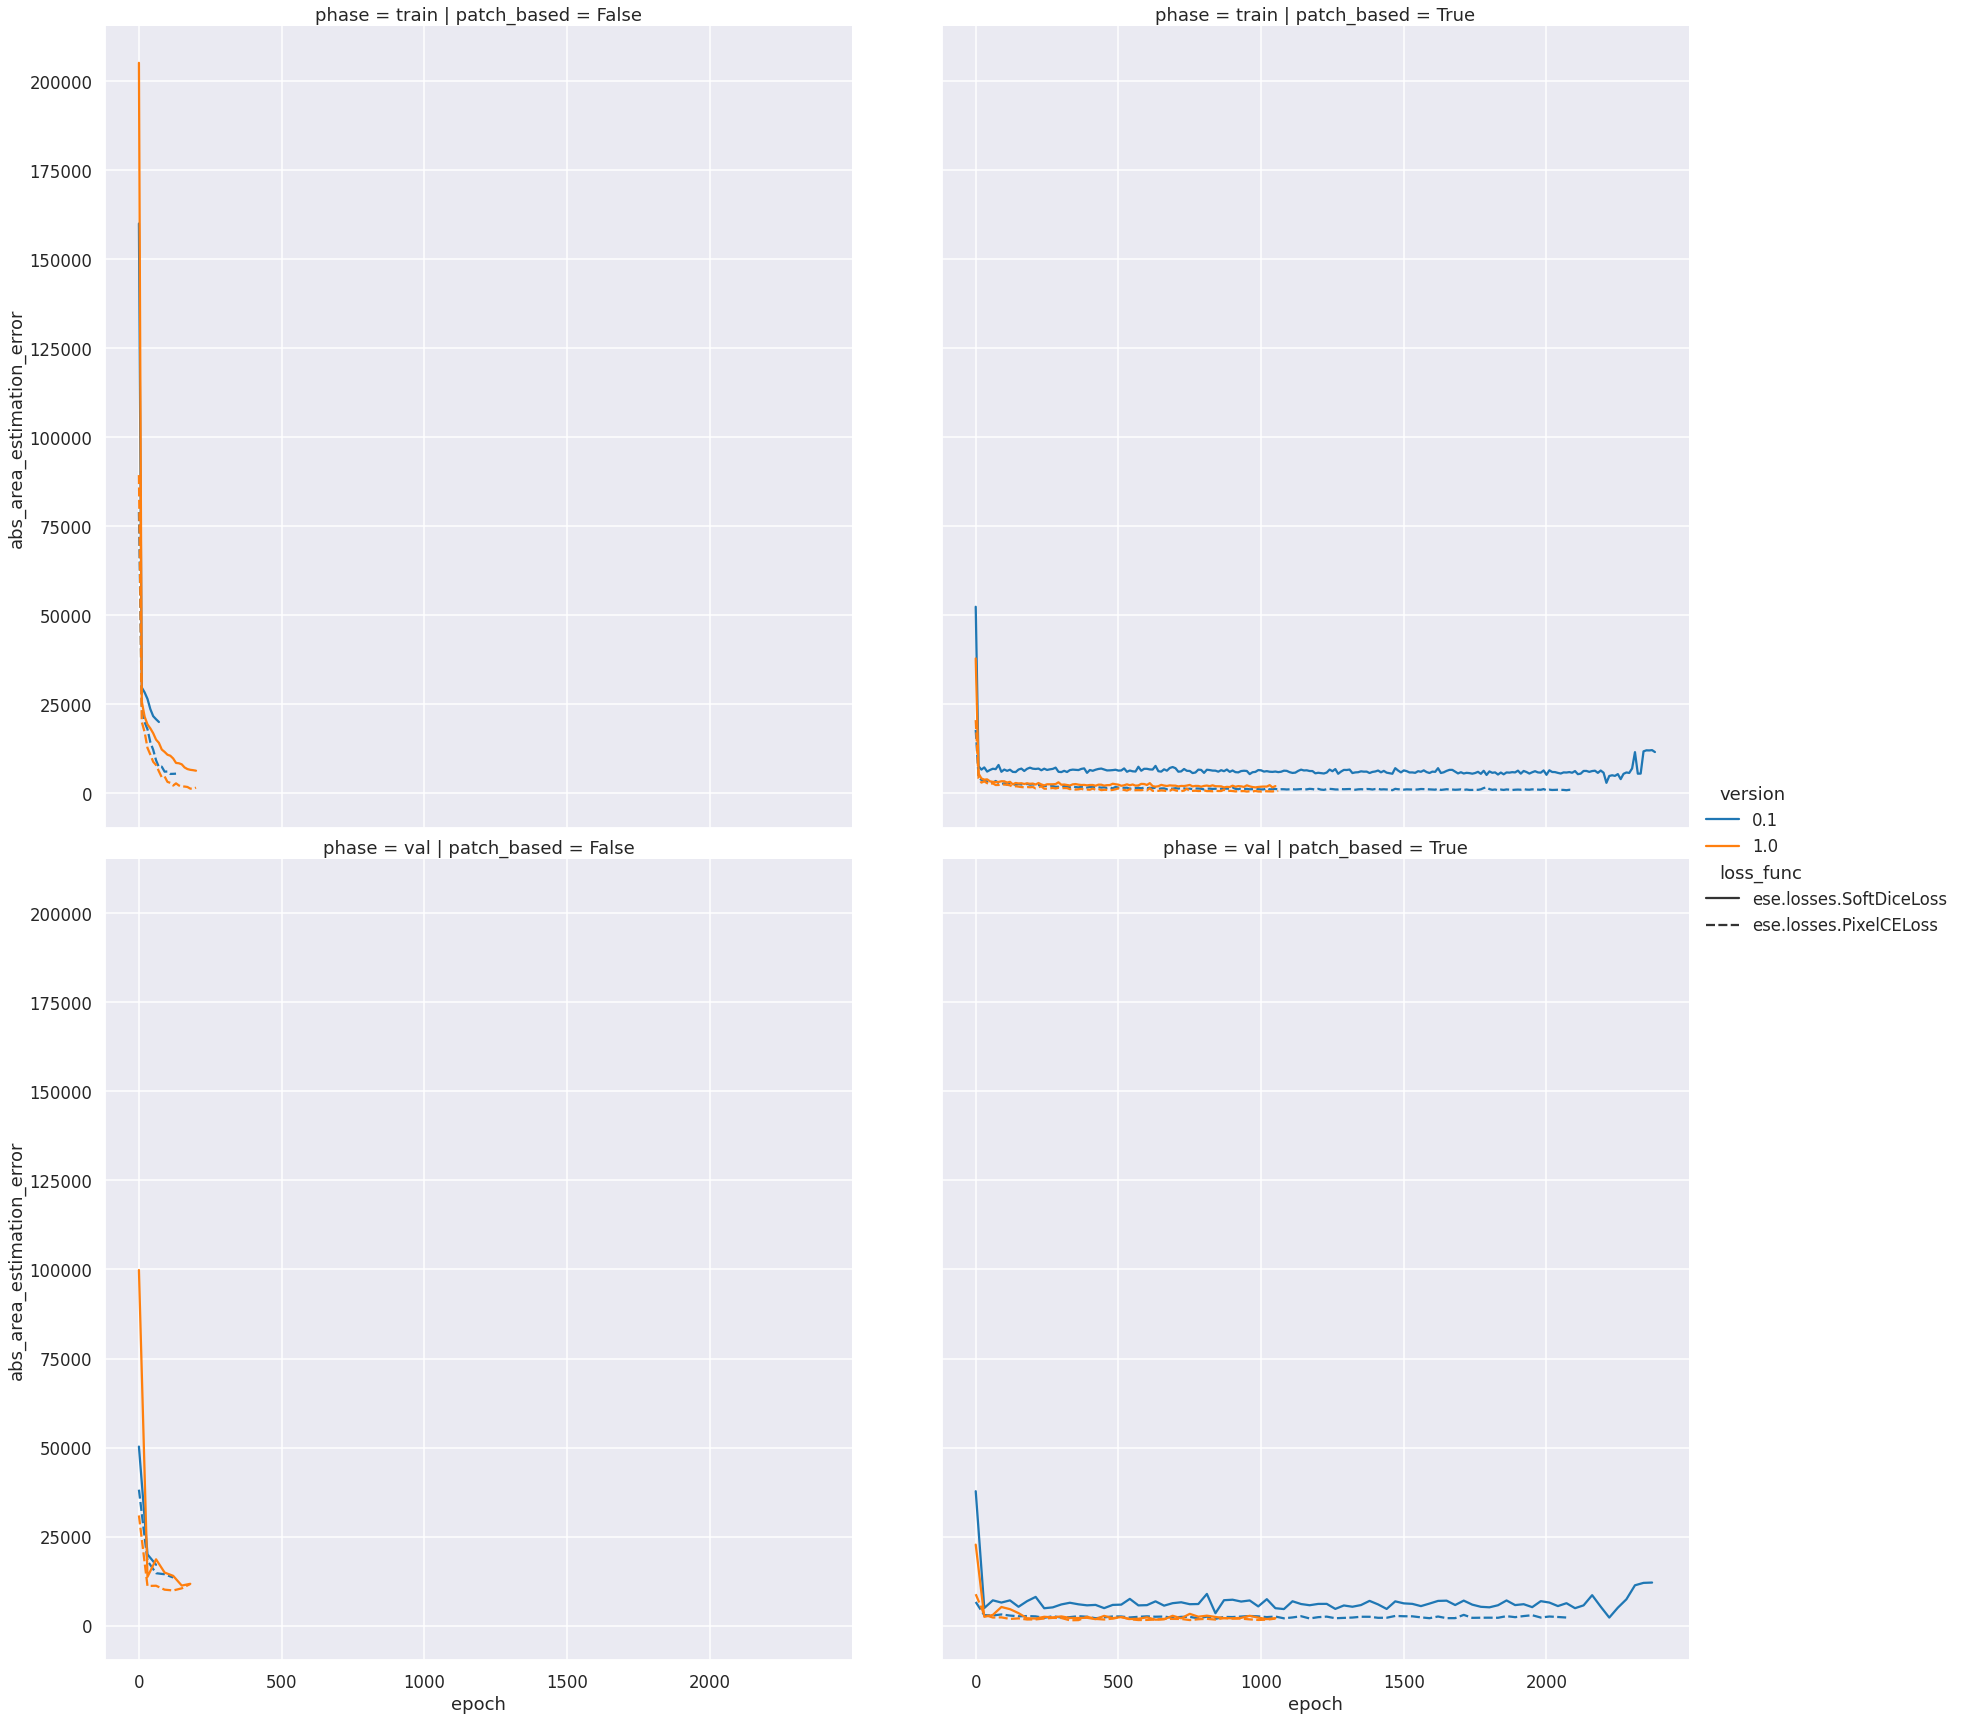

In [14]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='abs_area_estimation_error',
    hue='version',
    style='loss_func',
    row='phase',
    col='patch_based',
    kind='line',
    height=12,
    # facet_kws=dict(sharey=False),
)

# Set column spacig
g.fig.subplots_adjust(wspace=0.12)